In [1]:
# Start writing code here...
print("Hello World!")

Hello World!


1. Basic network description of your data (what type of network it is, what does it represent, is it real or synthetically generated, etc). In practice, the result of project phase #1 (finding data).

Scientific collaborations between authors of papers submitted to arxiv.org, under 5 categories: gr-qc, astro-ph, cond-mat, hep-ph, and hep-th categories, spanning January 1993 to April 2003. 

If an author i co-authored a paper with author j, the graph contains an undirected edge from i to j. If the paper is co-authored by k authors this generates a completely connected (sub)graph on k nodes (there is an edge if authors coauthored at least one paper).

We chose the network GrQc, which stands for General Relativity and Quantum Cosmology. 

General Relativity: General relativity, also known as the general theory of relativity and Einstein's theory of gravity, is the geometric theory of gravitation published by Albert Einstein in 1915 and is the current description of gravitation in modern physics.

Quantum Cosmology: Quantum cosmology is the attempt in theoretical physics to develop a quantum theory of the universe. This approach attempts to answer open questions of classical physical cosmology, particularly those related to the first phases of the universe.

2. Basic network statistics of your data (number of nodes, edges, clustering, degree distribution, etc). In practice, the result of project phase #2 (exploratory data analysis).

Number of nodes: 26,197

Number of edges: 28,980

Link til research paper:

http://www.cs.cmu.edu/~jure/pubs/powergrowth-tkdd.pdf

http://snap.stanford.edu/data/ca-GrQc.html


The analysis, results, and interpretation that allow you to answer your research question, the result of project phase #4.

In [2]:
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np


In [134]:
# Load data

edge_df = pd.read_csv("data/edges.csv", delimiter=",")
node_df = pd.read_csv("data/nodes.csv", delimiter=",")


In [135]:
# Turn into networkx graph

G = nx.from_pandas_edgelist(edge_df, source="# source", target=" target", create_using=nx.Graph())


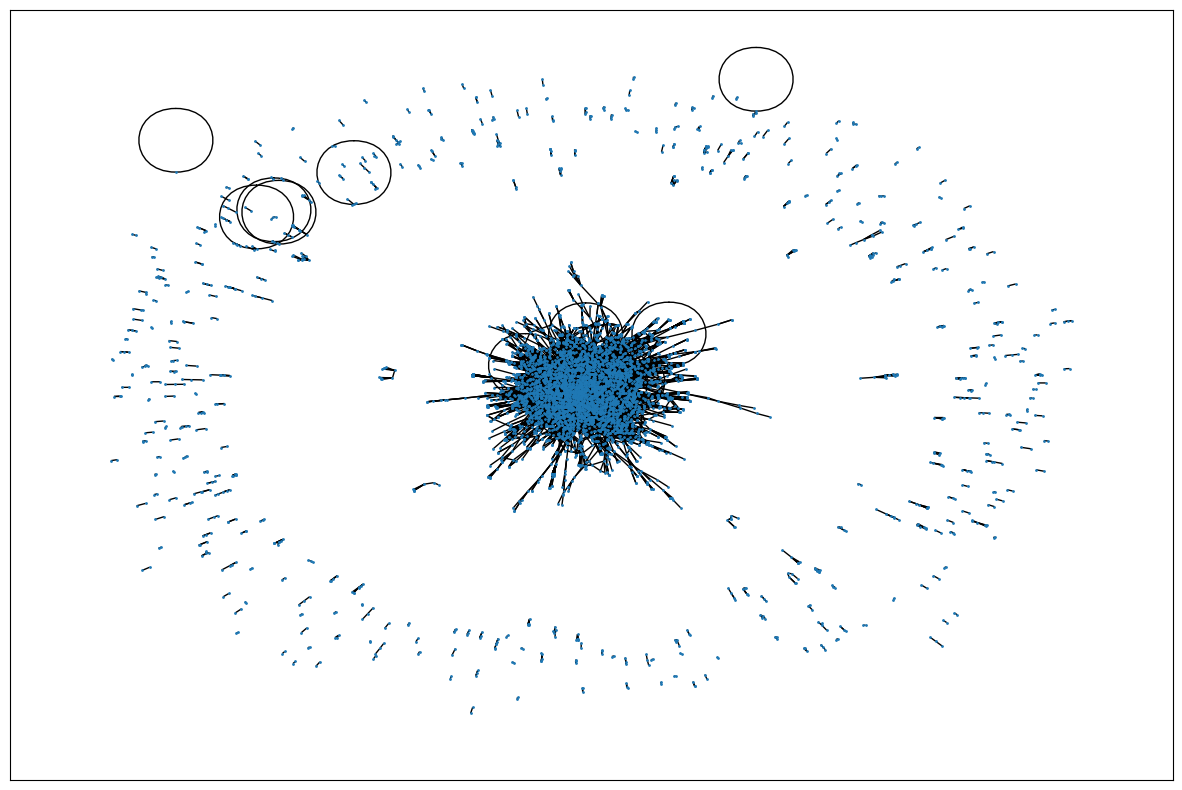

In [49]:
%%script echo skipping
fig, ax = plt.subplots(figsize=(15,10))

pos = nx.spring_layout(G, seed=7)
nx.draw_networkx_nodes(G, pos, node_size=1)
nx.draw_networkx_edges(G, pos)
plt.savefig("figures/graph_with_edges.png")

Transitivity is the overall probability for the network to have adjacent nodes interconnected, thus revealing the existence of tightly connected communities (or clusters, subgroups, cliques). 

In [50]:
# global clustering coefficient
nx.transitivity(G)

0.6298424741263426

https://graph-tool.skewed.de/static/doc/clustering.html?highlight=clustering


In [52]:
# average clustering coefficient
nx.average_clustering(G)

0.5296358110521365

In [148]:
# the fraction of all possible triangles present in G.
triangles = nx.triangles(G) # When computing triangles for the entire graph each 
# triangle is counted three times, once at each node.

# it returns a dictionary with the number of trianges keyed by node label.

In [55]:
nx.connected_components(G)


# a sorted list of connected components, largest first
#[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)] virker ikke helt


<generator object connected_components at 0x7f7348ed8190>

## 2

Basic network statistics of your data (number of nodes, edges, clustering, degree distribution, etc). In practice, the result of project phase #2 (exploratory data analysis).

## Degree Distribution

A degree distribution is a degree scatter plot, the degree on the x-axis and the number of nodes on the y-axis.

Commonly, one would normalise the y-axis by dividing its values by the number of nodes in the network, and the y-axis is the probability if a node to have a degree equal to k.

In [56]:
nx.degree(G)

DegreeView({13: 5, 7596: 1, 11196: 1, 19170: 1, 14: 1, 14171: 1, 22: 6, 106: 4, 11183: 3, 15793: 5, 19440: 3, 22618: 4, 25043: 5, 24: 4, 3858: 4, 15774: 1, 19517: 8, 23161: 4, 25: 1, 22891: 1, 26: 5, 1407: 6, 4550: 21, 11801: 11, 13096: 22, 13142: 28, 27: 4, 11114: 4, 19081: 4, 24726: 4, 25540: 8, 28: 1, 7916: 3, 29: 1, 20243: 4, 45: 49, 570: 48, 773: 55, 1186: 17, 1653: 56, 2212: 47, 2741: 65, 2952: 45, 3372: 49, 4164: 54, 4180: 6, 4511: 45, 4513: 43, 6179: 46, 6610: 68, 6830: 45, 7956: 56, 8879: 45, 9785: 68, 11241: 49, 11472: 45, 12365: 77, 12496: 48, 12679: 2, 12781: 57, 12851: 45, 14540: 46, 14807: 60, 15003: 62, 15659: 45, 17655: 66, 17692: 45, 18719: 22, 18866: 44, 18894: 47, 19423: 63, 19961: 45, 20108: 45, 20562: 45, 20635: 47, 21012: 81, 21281: 79, 21508: 67, 21847: 48, 22691: 77, 22887: 47, 23293: 53, 24955: 51, 25346: 56, 25758: 51, 46: 42, 62: 7, 2710: 33, 6575: 11, 7579: 2, 13190: 11, 16148: 18, 23751: 4, 25469: 7, 65: 7, 357: 4, 358: 2, 11609: 8, 22100: 9, 23300: 4, 2496

Generate a csv file containing the node and the corresponding degree of that node, and save it into the data folder as node_list_degrees.

In [57]:

node_df2 = pd.DataFrame(sorted(dict(nx.degree(G)).items()))
node_df2.rename(columns={0:"Node_id",1:"Degree"}, inplace=True)
node_df2.to_csv("data/node_list_degrees.csv", index=False)


Here we make a data frame with a count of the degrees. "k" is the number of degrees, and "count" is how many nodes have that corresponding degree. We make this data frame to help us with the degree distribution.

In [115]:
node_list_degrees = pd.read_csv("data/node_list_degrees.csv")

num_degrees = Counter(node_list_degrees["Degree"]) 

# Normalising y with the total number of nodes in the network. 
num_degrees = {key: value / len(G.nodes) for key, value in num_degrees.items()} 
degrees = num_degrees.keys()
counts = num_degrees.values()


pw = pd.DataFrame()
pw["k"] = degrees
pw["count"] = counts


/shared-libs/python3.8/py/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1041: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


<AxesSubplot: xlabel='k', ylabel='count'>

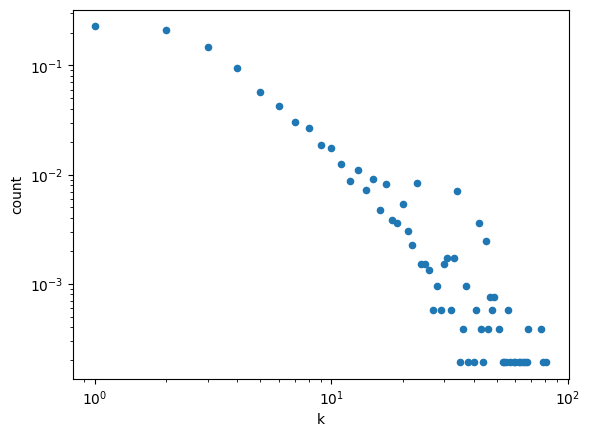

In [116]:
# plot the degrees against the number of nodes 


# With log-scale

pw.plot(x = "k", y = "count", kind = "scatter", loglog= True)

<AxesSubplot: xlabel='k', ylabel='count'>

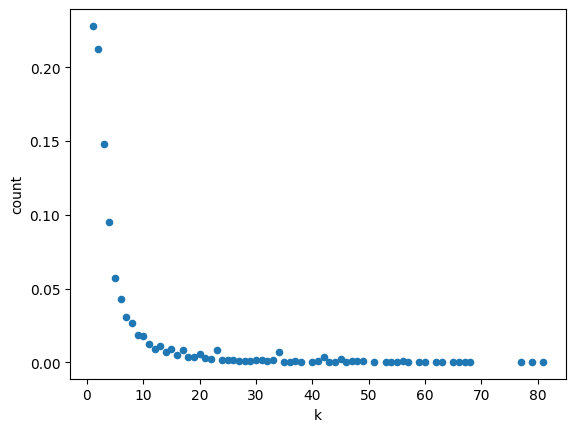

In [114]:
# without log-scale

pw.plot(x = "k", y = "count", kind = "scatter" )

### The CCDF of the degree distribution (the complement of a cumulative distribution function)
The most common way to visualize degrees is by drawing cumulative distributions (CDF)

To make the CCDF we need to know how many nodes have degree equal to, or higher than a specific value. So we sort the dataframe in descending degree order, so that the pandas cumsum function will calculate that for us. Then we normalize by the total degree sum, so that the count becomes a probability. We then sort in ascending degree value, to respect the convention.

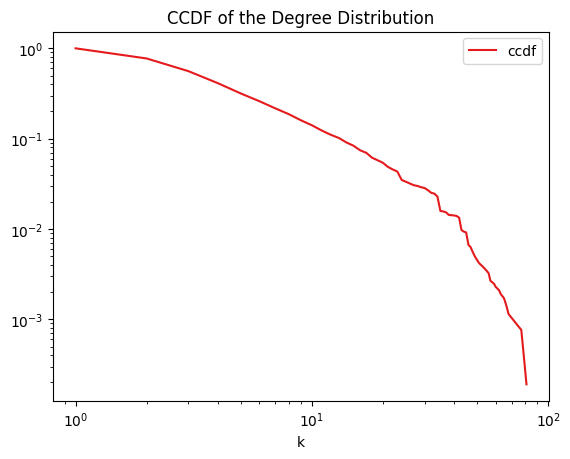

In [62]:
%%script echo skipping

from scripts.plots import CCDF
CCDF(pw)

Description of CCDF

y: the probability of finding a node of degree k or higher

x: degree

### Check for Power-law

Many networks have a power law degree distribution, but rarely this is a pure power law: it is often shifted or truncated. Fitting a power law and finding the correct exponent is tricky and you should not do it using a linear regression.

$p(k) \sim k^{-\alpha}$

In [63]:
from scipy.stats import linregress
import numpy as np
import powerlaw as pl


# define ccdf like in the plot function.
dd = Counter(dict(G.degree).values())
dd = pd.DataFrame(list(dd.items()), columns = ("k", "count")).sort_values(by = "k")
ccdf = dd.sort_values(by = "k", ascending = False)
ccdf["cumsum"] = ccdf["count"].cumsum()
ccdf["ccdf"] = ccdf["cumsum"] / ccdf["count"].sum()
ccdf = ccdf[["k", "ccdf"]].sort_values(by = "k")

# We take the logarithm in base 10 of both degree and CCDF. Then we simply do a linear regression. 
# The slope is  the exponent. The intercept needs to be the power of 10, to undo the logarithm operation. 
# Look at that r-squared!
logcdf = np.log10(ccdf[["k", "ccdf"]])
slope, log10intercept, r_value, p_value, std_err = linregress(logcdf["k"], logcdf["ccdf"])
print("CCDF Fit: %1.4f x ^ %1.4f (R2 = %1.4f, p = %1.4f)" % (10 ** log10intercept, slope, r_value ** 2, p_value))

CCDF Fit: 8.6089 x ^ -1.8811 (R2 = 0.8639, p = 0.0000)


In [64]:
# With the powerlaw package, fitting the CCDf is simple. It will store results in 
# the .power_law property. To get the actual k_min, we need to find the degree value 
# corresponding to the probability in .power_law.xmin:
# pandas makes it easy. This is definitely a shifted power law. 
# (Kappa contains the intercept information)

results = pl.Fit(ccdf["ccdf"])
k_min = ccdf[ccdf["ccdf"] == results.power_law.xmin]["k"]
print("Powerlaw CCDF Fit: %1.4f x ^ -%1.4f (k_min = %d)" % (10 ** results.power_law.Kappa, results.power_law.alpha, k_min))

Powerlaw CCDF Fit: 10.8487 x ^ -1.7804 (k_min = 34)
Calculating best minimal value for power law fit
/opt/conda/lib/python3.8/site-packages/powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /


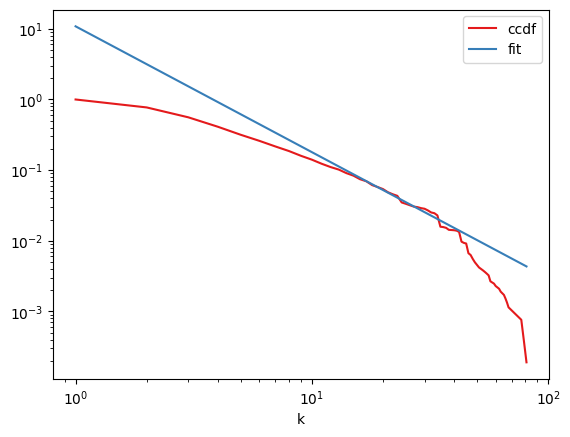

In [65]:
%%script echo skipping
# Let's plot the best fit.
ccdf["fit"] = (10 ** results.power_law.Kappa) * (ccdf["k"] ** -results.power_law.alpha)
ax = plt.gca()
ccdf.plot(kind = "line", x = "k", y = "ccdf", color = "#e41a1c", loglog = True, ax = ax)
ccdf.plot(kind = "line", x = "k", y = "fit", color = "#377eb8", loglog = True, ax = ax)
plt.savefig("ccdf_fit.png")

### Graph Density
The density of a graph is the ratio of observed edges to the number of possible edges for a network. In a graph that has 3 nodes, where all of them is connected, we would then expect $3 \cdot 2/2 = 3$ edges, and that is what we have. Its density is the maximum possible: 100%.

Another explanation count be, the number of edges in a network over the total possible number of edges that can exist given the number of nodes.

Our network/graph is undirected, so the formula we will use to calculate this is:

$d = \frac{2 \cdot |E|}{|V| \cdot  (|V| - 1)}$. We will calculate both ways, by using the formula, and by using the Network X function for density `density()`.

The density for a graph would be 0 if there are none edges, and the density for a graph would be 1 if the graph is complete. Meaning that if all the nodes was multiplied by itself, minus 1 node, then the graph would be complete and have a density of 1.

In [66]:
# Graph density with a formula.
# edges |E| is m
# nodes |V| is n

n = 26197
m = 28980

# This is the density formula for a undirected graph:
d = 2 * m / (n * (n - 1))
print(f'This is the density of an undirected graph, calculated using the formula: {d}')

This is the density of an undirected graph, calculated using the formula: 8.445820264096778e-05


We would expect a very low density, since real world networks are very sparse. The density of a network goes down as you increase the number of nodes, which makes sense, since the denominator of the density formula grows quadratically.

In [67]:

def number_of_nodes(G):
# This will return the number of nodes
    return G.number_of_nodes()

def number_of_edges(G):
# This will return the number of edges
    return G.number_of_edges()

def density(G):
# We define the number of nodes and edges of the graph
    n = number_of_nodes(G)
    m = number_of_edges(G)
# We make an if-statement: if edge is 0 or node is less than or equal to 1, we return the number 0, meaning there is no edge.
    if m == 0 or n <= 1:
        return 0
# We then calculate the density, using the formula for a directed graph.
    d = m / (n * (n - 1))

# We make an if-statement: if the graph is NOT directed (which ours isn't) we will multiply the density with 2 (due to undirectedness)
    if not G.is_directed():
        d *= 2
        return d

# Graph density with networkx
print(f'This is the density of an undirected graph, calculated using the NetworkX function: {nx.density(G)}')

This is the density of an undirected graph, calculated using the NetworkX function: 0.001055278280507905


### Result for density
This number means that the graph is very sparse. The closer to 0, the less connected the graph is, and the closer to 1, the more complete the graph is. Our result is $0.0.0005403...$ meaning our graph is not that connected/dense.

In [ ]:
#Clustering (triangles)

clustering_dict=nx.triangles(G) #This is the dictionary for clustering for the undirected graph

print(clustering_dict)

{1: 0, 3: 0, 4: 0, 2: 0, 428: 0, 435: 0, 436: 0, 437: 0, 438: 0, 432: 1, 458: 0, 459: 0, 460: 1, 478: 0, 523: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 3644: 1, 3680: 0, 3397: 1, 3751: 0, 3830: 0, 10: 0, 11: 0, 3454: 0, 3535: 0, 12: 0, 13: 0, 4935: 0, 4936: 0, 14: 0, 15: 0, 115: 0, 119: 0, 125: 2, 171: 0, 173: 0, 174: 0, 175: 0, 16: 0, 17: 0, 18: 0, 32: 0, 33: 0, 34: 0, 35: 0, 47: 0, 19: 0, 20: 0, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 0, 131: 0, 132: 0, 106: 0, 67: 0, 198: 1, 205: 0, 226: 1, 31: 0, 61: 2, 29: 0, 30: 1, 59: 2, 60: 2, 99: 0, 177: 0, 178: 0, 179: 0, 36: 0, 37: 0, 38: 0, 39: 0, 96: 0, 167: 0, 44: 0, 68: 0, 117: 0, 40: 0, 41: 0, 42: 0, 43: 0, 190: 0, 45: 0, 163: 0, 245: 0, 255: 0, 46: 0, 48: 0, 111: 0, 65: 0, 49: 0, 50: 1, 110: 2, 127: 1, 51: 0, 52: 1, 55: 1, 153: 0, 168: 1, 530: 0, 540: 0, 53: 0, 54: 0, 116: 0, 218: 0, 4523: 0, 56: 0, 57: 1, 58: 0, 93: 1, 95: 1, 128: 0, 222: 0, 62: 0, 71: 2, 63: 0, 64: 0, 231: 0, 66: 0, 94: 0, 126: 0, 154: 0, 166: 0, 184: 0, 185: 0, 

## Node Ranking

### Closeness Centrality

The closeness centrality of a node $v$, is all the shortest paths starting from that node to every possible destination in the network. Each of these paths has a length $(|P_{uv}|)$. We sum these lengths and average that value over the number of all possible destinations (which is the number of nodes in the network minus one)

Closeness centrality measures how short the shortest paths are from node i to all nodes.

 $\text{Closeness Centrality} = \frac{(|V| -1)}{\sum_{u} |P_{uv}|}$

In [68]:
%%script echo Skipping!
closeness_centrality_dict = nx.closeness_centrality(G)

In [70]:
# closeness_centrality_dict

### Betweenness Centrality
Differently from closeness, with betweenness we are not counting distances, but paths. If we want to know the betweenness of node $v$, we count the number of paths passing through $v$ - but of which $v$ is neither an origin nor a destination.
The betweenness of an edge is the (normalised) count of shortest paths using the edge.

The more shortest paths that passes through you, the more important you are.

In [123]:
%%script echo Skipping!
betweenness_centrality_dict = nx.betweenness_centrality(G)

In [147]:
betweenness_centrality_df = pd.DataFrame(betweenness_centrality_dict.items())
betweenness_centrality_df.columns = ['node_id', 'betweenness_centrality']
betweenness_centrality_df.head()

,node_id,betweenness_centrality
0,13,2.184770e-07
1,7596,0.000000e+00
2,11196,0.000000e+00
3,19170,0.000000e+00
4,14,0.000000e+00


In [146]:
betweenness_centrality_df.to_csv("data/betweenness_centrality.csv", index=False)
betweenness_df = pd.read_csv("data/betweenness_centrality.csv")

### Reach Centrality

The local reach centrality of a node v is the fraction of nodes in a network that you can reach starting from $v$.

Maybe not relevant

## Average path length

Here we find the avearge shorests path length. We are also working on a dist. of the shoreste paths length.

In [ ]:
%%script echo skipping
nx.average_shortest_path_length(G)


skipping


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6f843856-fc0a-4528-82df-ce4d1b752717' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>